# 2022-09-19 Blasius

## Last time

* NLsolve Newton solver library
  * p-Laplacian robustness
  * diagnostics
* Algorithmic differentiation via Zygote
* Symbolic differentiation

## Today
* Structured by-hand differentiation
* Concept of PDE-based inference (inverse problems)
* The Blasius problem (activity)
* Intro to transient problems

In [4]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays

function vander(x, k=nothing)
    if k === nothing
        k = length(x)
    end
    V = ones(length(x), k)
    for j = 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function fdstencil(source, target, k)
    "kth derivative stencil from source to target"
    x = source .- target
    V = vander(x)
    rhs = zero(x)'
    rhs[k+1] = factorial(k)
    rhs / V
end

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end


function advdiff_sparse(n, kappa, wind, forcing)
    x = LinRange(-1, 1, n)
    xstag = (x[1:end-1] + x[2:end]) / 2
    rhs = forcing.(x)
    kappa_stag = kappa.(xstag)
    rows = [1, n]
    cols = [1, n]
    vals = [1., 1.] # diagonals entries (float)
    rhs[[1,n]] .= 0 # boundary condition
    for i in 2:n-1
        flux_L = -kappa_stag[i-1] * fdstencil(x[i-1:i], xstag[i-1], 1) +
            wind * (wind > 0 ? [1 0] : [0 1])
        flux_R = -kappa_stag[i] * fdstencil(x[i:i+1], xstag[i], 1) +
            wind * (wind > 0 ? [1 0] : [0 1])
        weights = fdstencil(xstag[i-1:i], x[i], 1)
        append!(rows, [i,i,i])
        append!(cols, i-1:i+1)
        append!(vals, weights[1] *  [flux_L..., 0] + weights[2] * [0, flux_R...])
    end
    L = sparse(rows, cols, vals)
    x, L, rhs
end

function newton(residual, jacobian, u0; maxits=20)
    u = u0
    uhist = [copy(u)]
    normhist = []
    for k in 1:maxits
        f = residual(u)
        push!(normhist, norm(f))
        J = jacobian(u)
        delta_u = - J \ f
        u += delta_u
        push!(uhist, copy(u))
    end
    uhist, normhist
end

newton (generic function with 1 method)

# $p$-Laplacian

$$ -\big(|u_x|^{p-2} u_x\big)_x = 0 $$

In [5]:
plaplace_p = 1.5
plaplace_forcing = 0.
function plaplace_f(u)
    n = length(u)
    h = 2 / (n - 1)
    u = copy(u)
    f = copy(u)
    u[[1, n]] = [0, 1]
    f[n] -= 1
    for i in 2:n-1
        u_xstag = diff(u[i-1:i+1]) / h
        kappa_stag = abs.(u_xstag) .^ (plaplace_p - 2)
        f[i] = [1/h, -1/h]' *
            (kappa_stag .* u_xstag) - plaplace_forcing
    end
    f
end

plaplace_f (generic function with 1 method)

In [6]:
function plaplace_J(u)
    n = length(u)
    h = 2 / (n - 1)
    u = copy(u)
    u[[1, n]] = [0, 1]
    rows = [1, n]
    cols = [1, n]
    vals = [1., 1.] # diagonals entries (float)
    for i in 2:n-1
        js = i-1:i+1
        u_xstag = diff(u[js]) / h
        kappa_stag = abs.(u_xstag) .^ (plaplace_p - 2)
        fi = [h, -h]' * (kappa_stag .* u_xstag)
        fi_ujs = [-kappa_stag[1]/h^2,
                  sum(kappa_stag)/h^2,
                  -kappa_stag[2]/h^2]
        mask = 1 .< js .< n
        append!(rows, [i,i,i][mask])
        append!(cols, js[mask])
        append!(vals, fi_ujs[mask])
    end
    sparse(rows, cols, vals)
end

plaplace_J (generic function with 1 method)

# Try solving

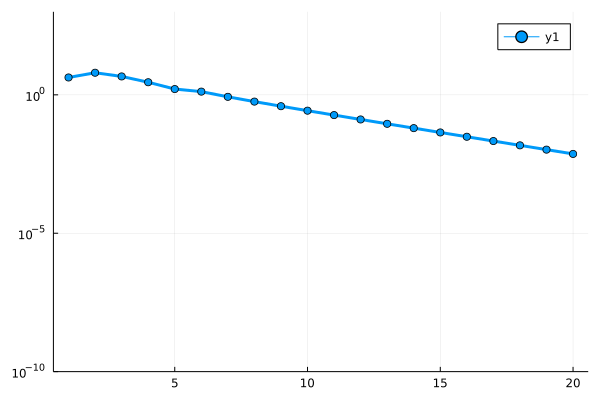

In [106]:
n = 20
x = collect(LinRange(-1., 1, n))
u0 = (1 .+ x) / 2

plaplace_p = 1.3 # try different values
plaplace_forcing = 1
uhist, normhist = newton(plaplace_f, plaplace_J, u0; maxits=20);
plot(normhist, marker=:circle, yscale=:log10, ylims=(1e-10, 1e3))

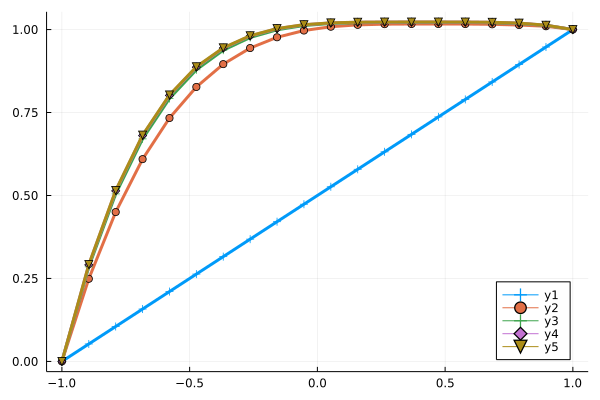

In [107]:
plot(x, uhist[1:5:end], marker=:auto, legend=:bottomright)

## What's wrong?

# Using Zygote to differentiate

In [108]:
using Zygote

gradient(x -> x^2, 3)

(6.0,)

In [109]:
function plaplace_fpoint(u, h)
    u_xstag = diff(u) / h
    kappa_stag = abs.(u_xstag) .^ (plaplace_p - 2)
    [1/h, -1/h]' * (kappa_stag .* u_xstag)
end

gradient(u -> plaplace_fpoint(u, .1), [0., .7, 1.])

([-7.683385553661419, 21.58727725682051, -13.903891703159092],)

# p-Laplacian with Zygote

In [11]:
function plaplace_fzygote(u)
    n = length(u)
    h = 2 / (n - 1)
    u = copy(u)
    f = copy(u)
    u[[1, n]] = [0, 1]
    f[n] -= 1
    for i in 2:n-1
        f[i] = plaplace_fpoint(u[i-1:i+1], h) - plaplace_forcing
    end
    f
end

plaplace_fzygote (generic function with 1 method)

In [12]:
function plaplace_Jzygote(u)
    n = length(u)
    h = 2 / (n - 1)
    u = copy(u)
    u[[1, n]] = [0, 1]
    rows = [1, n]
    cols = [1, n]
    vals = [1., 1.] # diagonals entries (float)
    for i in 2:n-1
        js = i-1:i+1
        fi_ujs = gradient(ujs -> plaplace_fpoint(ujs, h), u[js])[1]
        mask = 1 .< js .< n
        append!(rows, [i,i,i][mask])
        append!(cols, js[mask])
        append!(vals, fi_ujs[mask])
    end
    sparse(rows, cols, vals)
end

plaplace_Jzygote (generic function with 1 method)

# Experiment with parameters

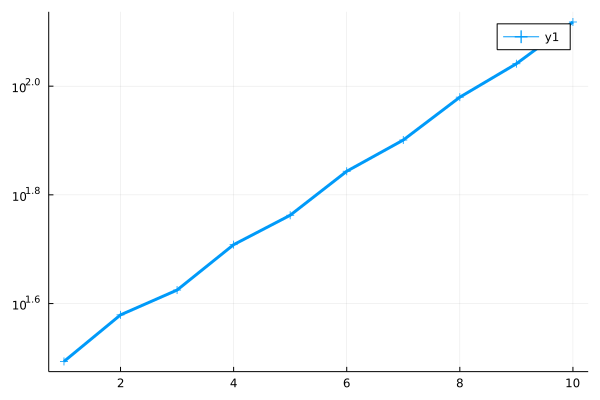

In [117]:
plaplace_p = 1.4
plaplace_forcing = 1
u0 = (x .+ 1)
uhist, normhist = newton(plaplace_fzygote, plaplace_Jzygote, u0; maxits=10);
plot(normhist, marker=:auto, yscale=:log10)

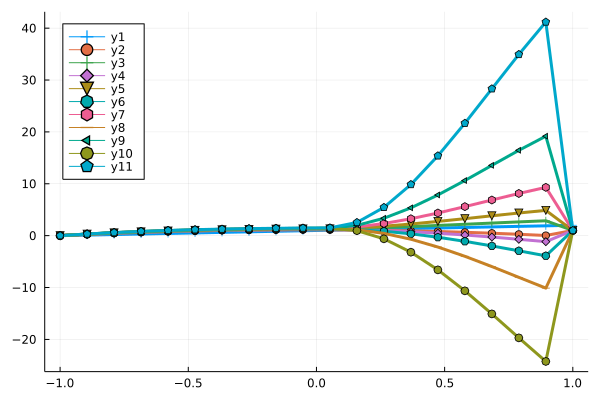

In [118]:
plot(x, uhist, marker=:auto, legend=:topleft)

* Can you fix the `plaplace_J` to differentiate correctly (analytically)?
* What is causing Newton to diverge?
* How might we fix or work around it?

# A model problem for Newton divergence; compare NLsolve

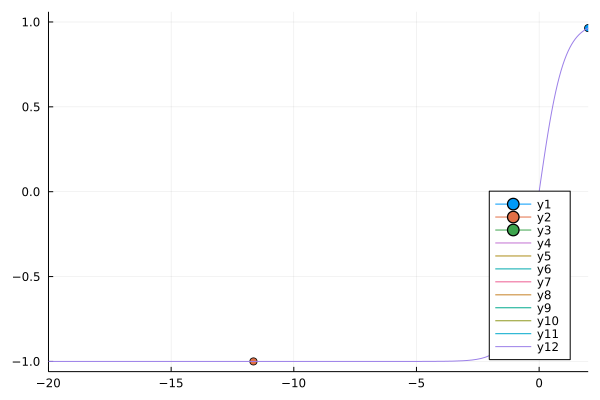

In [122]:
k = 1. # what happens as this is changed
fk(x) = tanh.(k*x)
Jk(x) = reshape(k / cosh.(k*x).^2, 1, 1)
xhist, normhist = newton(fk, Jk, [2.], maxits=10)
plot(xhist, fk.(xhist), marker=:circle, legend=:bottomright)
plot!(fk, xlims=(-20, 2), linewidth=1)

In [126]:
using NLsolve

nlsolve(x -> fk(x) .+ .5, Jk, [5.], show_trace=true)

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.499909e+00              NaN
     1     5.000000e-01     5.000000e+00
     2     3.788284e-02     5.000000e-01
     3     8.529212e-04     4.816956e-02
     4     4.836986e-07     1.135938e-03
     5     1.559863e-13     6.449311e-07


Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [5.0]
 * Zero: [-0.5493061443338468]
 * Inf-norm of residuals: 0.000000
 * Iterations: 5
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 6
 * Jacobian Calls (df/dx): 6

# [NLsolve](https://juliapackages.com/p/nlsolve) for p-Laplacian

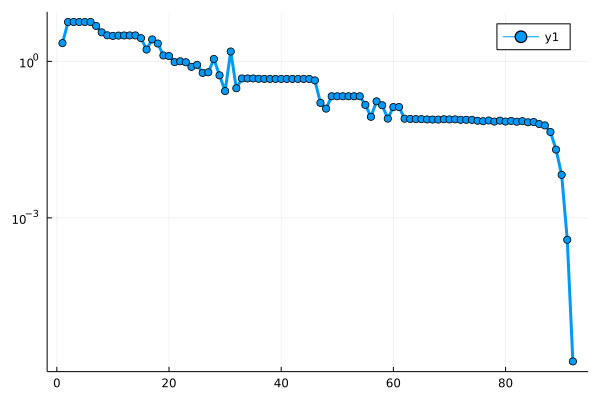

In [133]:
plaplace_p = 1.5
plaplace_forcing = 1
u0 = (x .+ 1) / 2
sol = nlsolve(plaplace_fzygote, plaplace_Jzygote, u0, 
    store_trace=true)
plaplace_p = 1.3
sol = nlsolve(plaplace_fzygote, plaplace_Jzygote, sol.zero, 
    store_trace=true)
fnorms = [sol.trace[i].fnorm for i in 1:sol.iterations]
plot(fnorms, marker=:circle, yscale=:log10)

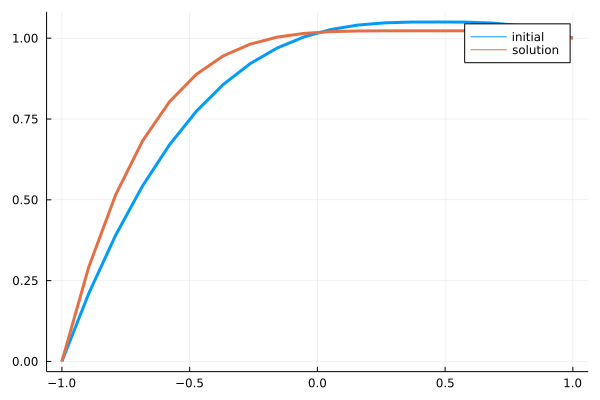

In [134]:
plot(x, [sol.initial_x sol.zero], label=["initial" "solution"])

# What about symbolic differentiation?

In [136]:
import Symbolics: Differential, expand_derivatives, @variables
@variables x
Dx = Differential(x)
y = tanh(k*x)
Dx(y)

Differential(x)(tanh(x))

In [137]:
expand_derivatives(Dx(y))

1 - (tanh(x)^2)

# Cool, what about composition of functions

In [140]:
y = x
for _ in 1:2
    y = cos(y^pi) * log(y)
end
expand_derivatives(Dx(y))

((x^-1)*cos(x^π) - 3.141592653589793(x^2.141592653589793)*log(x)*sin(x^π))*(log(x)^-1)*(cos(x^π)^-1)*cos((log(x)^3.141592653589793)*(cos(x^π)^3.141592653589793)) - (3.141592653589793(x^-1)*(log(x)^2.141592653589793)*(cos(x^π)^3.141592653589793) - 9.869604401089358(x^2.141592653589793)*(log(x)^3.141592653589793)*(cos(x^π)^2.141592653589793)*sin(x^π))*sin((log(x)^3.141592653589793)*(cos(x^π)^3.141592653589793))*log(log(x)*cos(x^π))

* The size of these expressions can grow **exponentially**.

# Hand coding derivatives: it's all chain rule and associativity
$$ df = f'(x) dx $$

In [141]:
function f(x)
    y = x
    for _ in 1:2
        a = y^pi
        b = cos(a)
        c = log(y)
        y = b * c
    end
    y
end

f(1.9), gradient(f, 1.9)

(-1.5346823414986814, (-34.03241959914049,))

In [142]:
function df(x, dx)
    y = x
    dy = dx
    for _ in 1:2
        a = y^pi
        da = pi * y^(pi-1) * dy
        b = cos(a)
        db = -sin(a) * da
        c = log(y)
        dc = 1/y * dy
        y = b * c
        dy = db * c + b * dc
    end
    dy
end

df(1.9, 1)

-34.03241959914048

# We can go the other way

We can differentiate a composition $h(g(f(x)))$ as

\begin{align}
  \operatorname{d} h &= h' \operatorname{d} g \\
  \operatorname{d} g &= g' \operatorname{d} f \\
  \operatorname{d} f &= f' \operatorname{d} x.
\end{align}

What we've done above is called "forward mode", and amounts to placing the parentheses in the chain rule like

$$ \operatorname d h = \frac{dh}{dg} \left(\frac{dg}{df} \left(\frac{df}{dx} \operatorname d x \right) \right) .$$

The expression means the same thing if we rearrange the parentheses,

$$ \operatorname d h = \left( \left( \left( \frac{dh}{dg} \right) \frac{dg}{df} \right) \frac{df}{dx} \right) \operatorname d x $$

which we can compute with in reverse order via

$$ \underbrace{\bar x}_{\frac{dh}{dx}} = \underbrace{\bar g \frac{dg}{df}}_{\bar f} \frac{df}{dx} .$$

# A reverse mode example

$$ \underbrace{\bar x}_{\frac{dh}{dx}} = \underbrace{\bar g \frac{dg}{df}}_{\bar f} \frac{df}{dx} .$$

In [52]:
function g(x)
    a = x^pi
    b = cos(a)
    c = log(x)
    y = b * c
    y
end
(g(1.4), gradient(g, 1.4))

(-0.32484122107701546, (-1.2559761698835525,))

In [53]:
function gback(x, y_)
    a = x^pi
    b = cos(a)
    c = log(x)
    y = b * c
    # backward pass
    c_ = y_ * b 
    b_ = c * y_
    a_ = -sin(a) * b_
    x_ = 1/x * c_ + pi * x^(pi-1) * a_
    x_
end
gback(1.4, 1)

-1.2559761698835525

# Kinds of algorithmic differentation

* Source transformation: Fortran code in, Fortran code out
  * Duplicates compiler features, usually incomplete language coverage
  * Produces efficient code
* Operator overloading: C++ types
  * Hard to vectorize
  * Loops are effectively unrolled/inefficient
* Just-in-time compilation: tightly coupled with compiler
  * JIT lag
  * Needs dynamic language features (JAX) or tight integration with compiler (Zygote, Enzyme)
  * Some [sharp bits](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#control-flow)

# How does Zygote work?

In [144]:
h1(x) = x^3 + 3*x
h2(x) = ((x * x)  + 3) * x
@code_llvm h1(4.)

;  @ In[144]:1 within `h1`
define double @julia_h1_18050(double %0) #0 {
top:
; ┌ @ intfuncs.jl:322 within `literal_pow`
; │┌ @ operators.jl:591 within `*` @ float.jl:385
    %1 = fmul double %0, %0
    %2 = fmul double %1, %0
; └└
; ┌ @ promotion.jl:389 within `*` @ float.jl:385
   %3 = fmul double %0, 3.000000e+00
; └
; ┌ @ float.jl:383 within `+`
   %4 = fadd double %3, %2
; └
  ret double %4
}


In [55]:
@code_llvm gradient(h1, 4.)

;  @ /home/jed/.julia/packages/Zygote/xGkZ5/src/compiler/interface.jl:95 within `gradient`
define [1 x double] @julia_gradient_15323(double %0) #0 {
top:
;  @ /home/jed/.julia/packages/Zygote/xGkZ5/src/compiler/interface.jl:97 within `gradient`
; ┌ @ /home/jed/.julia/packages/Zygote/xGkZ5/src/compiler/interface.jl:45 within `#60`
; │┌ @ In[54]:1 within `Pullback`
; ││┌ @ /home/jed/.julia/packages/Zygote/xGkZ5/src/compiler/chainrules.jl:206 within `ZBack`
; │││┌ @ /home/jed/.julia/packages/Zygote/xGkZ5/src/lib/number.jl:12 within `literal_pow_pullback`
; ││││┌ @ intfuncs.jl:321 within `literal_pow`
; │││││┌ @ float.jl:385 within `*`
        %1 = fmul double %0, %0
; ││││└└
; ││││┌ @ promotion.jl:389 within `*` @ float.jl:385
       %2 = fmul double %1, 3.000000e+00
; │└└└└
; │┌ @ /home/jed/.julia/packages/Zygote/xGkZ5/src/lib/lib.jl:17 within `accum`
; ││┌ @ float.jl:383 within `+`
     %3 = fadd double %2, 3.000000e+00
; └└└
;  @ /home/jed/.julia/packages/Zygote/xGkZ5/src/compiler/inte

# Forward or reverse?

It all depends on the shape.

$$ \operatorname d h = \frac{dh}{dg} \left(\frac{dg}{df} \left(\frac{df}{dx} \operatorname d x \right) \right) .$$

$$ \operatorname d h = \left( \left( \left( \frac{dh}{dg} \right) \frac{dg}{df} \right) \frac{df}{dx} \right) \operatorname d x $$

* One input, many outputs: use forward mode
  * "One input" can be looking in one direction
* Many inputs, one output: use reverse mode
  * Will need to traverse execution backwards ("tape")
  * Hierarchical checkpointing
* About square? Forward is usually a bit more efficient.

# Inference using PDE-based models

<img src="https://crikit.science/_images/diagram.png" width="100%" />

# [Compressible Blasius boundary layer](https://en.wikipedia.org/wiki/Blasius_boundary_layer#Compressible_Blasius_boundary_layer)

* Activity will solve this 1D nonlinear PDE